In [1]:
import os, sys, pickle
import numpy as np
from tqdm import tqdm_notebook as tqdm
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path = list(set(sys.path))
import matplotlib.pyplot as plt
%matplotlib inline

from results_path import DDPG_PATH, PPO_PATH

from common.evaluate import make_vis_env, test_env

from flow.multiagent_envs import MultiWaveAttenuationMergePOEnv
from flow.scenarios import MergeScenario
from flow.utils.registry import make_create_env
from flow.utils.rllib import FlowParamsEncoder
from flow.core.params import InFlows
from ray.tune import run_experiments

import gym, ray
from ray.rllib.agents.ppo import PPOAgent, DEFAULT_CONFIG
from ray.rllib.agents.ddpg import DDPGAgent, DEFAULT_CONFIG
from ray.tune.registry import register_env
from ray.tune.logger import pretty_print

benchmark_name = 'multi_merge'
exp_name = 'random_env'
results_list = os.listdir('/headless/ray_results/' + exp_name)
AGENT = 'HUMAN' # 'PPO' or 'DDPG' or 'HUMAN'
checkpoint = '200'

benchmark = __import__(
    "flow.benchmarks.%s" % benchmark_name, fromlist=["flow_params"])
flow_params = benchmark.buffered_obs_flow_params

ray.init(num_cpus=1, include_webui=False, ignore_reinit_error=True)

Process STDOUT and STDERR is being redirected to /tmp/ray/session_2019-05-01_16-27-16_1167/logs.
Waiting for redis server at 127.0.0.1:27393 to respond...
Waiting for redis server at 127.0.0.1:20886 to respond...
Starting the Plasma object store with 13.355121049 GB memory using /dev/shm.


{'node_ip_address': '169.237.32.118',
 'object_store_addresses': ['/tmp/ray/session_2019-05-01_16-27-16_1167/sockets/plasma_store'],
 'raylet_socket_names': ['/tmp/ray/session_2019-05-01_16-27-16_1167/sockets/raylet'],
 'redis_address': '169.237.32.118:27393',
 'webui_url': ''}

In [2]:
horizon = flow_params['env'].horizon
create_env, env_name = make_create_env(params=flow_params, version=0)

# Register as rllib env
register_env(env_name, create_env)

In [3]:
render = False
env = None
if render:
    env = make_vis_env(flow_params, MultiWaveAttenuationMergePOEnv, MergeScenario)
else: 
    env = create_env()

 Starting SUMO on port 52992


In [4]:
# calculate the space-time velocity map
left_length = env.k.scenario.edge_length('left')
car_length = 5.0
scale = 10
vel_lists = []
vel_map_lists = []
outflow_lists = []

num_iter = 1 if render else 6
for _ in tqdm(range(100)):
    state = env.reset()
    vel = []
    outflow = []
    for i in tqdm(range(env.env_params.horizon)):
        # record the mean velocity
        v = np.mean(env.k.vehicle.get_speed(env.k.vehicle.get_ids()))
        vel.append(v)

        # record the velocity map
        ids = env.k.vehicle.get_ids()
        vel_map_ = np.zeros(int(left_length)*scale)
        for id_ in ids:
            pos_ = np.round(env.k.vehicle.get_position(id_), decimals=1)
            vel_ = env.k.vehicle.get_speed(id_)
            pos_bottom = max(0, int((pos_-car_length/2.0)*scale))
            pos_top = min(int(left_length)*scale, int((pos_+car_length/2.0)*scale))
            vel_map_[pos_bottom:pos_top] = vel_            

        # step the simulation
        rl_ids = env.k.vehicle.get_rl_ids()
        actions = {}
        if AGENT != 'HUMAN':
            for id_ in rl_ids:
                action = agent.compute_action(state[id_])
                actions.update({id_: action})
        state, r, _, _ = env.step(actions)
        outflow.append(env.k.vehicle.get_outflow_rate(600)) # measured by one min

        if i == 0:
            vel_map_list = vel_map_
        else:
            vel_map_list = np.vstack((vel_map_list, vel_map_))

    outflow_lists.append(outflow[-500:])
    vel_lists.append(vel)
    vel_map_list[vel_map_list==0.0] = np.nan
    vel_map_lists.append(vel_map_list)

 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO on port 52992
 Starting SUMO

In [5]:
vel_lists = np.array(vel_lists)
vel_mean_lists = np.mean(vel_lists, axis=0)

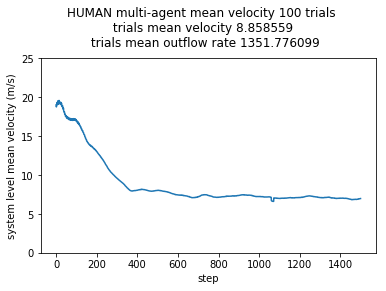

In [6]:
vel_fig, ax = plt.subplots(nrows=1, ncols=1)
ax.plot(vel_mean_lists)
title = AGENT + ' multi-agent mean velocity 100 trials'
title = title + ' \n trials mean velocity {:3f}'.format(np.mean(vel_lists))
title = title + ' \n trials mean outflow rate {:3f}'.format(np.mean(outflow_lists))
ax.set_ylim((0, 25))
ax.set_ylabel('system level mean velocity (m/s)')
ax.set_xlabel('step')
vel_fig.suptitle(title)
plt.subplots_adjust(top=0.8)

In [7]:
if not render:
    if AGENT == 'HUMAN':
        filename = 'HUMAN_100.png'
        vel_dir = '../result/MultiMerge/' + AGENT + '/mean_velocity/'
        space_dir = '../result/MultiMerge/' + AGENT + '/space_time_diagram/'
    os.makedirs(vel_dir, exist_ok=True)

    vel_fig.savefig(vel_dir + filename)

In [8]:
np.save('human_100.npy', vel_mean_lists)

In [9]:
np.save('human_100_outflow.npy', outflow_lists)